In [1]:
# Lertas Giorgos 

# import libraries
import pandas as pd
import numpy as np
import os 
import math
import matplotlib.pyplot as plt
import seaborn as sns

from platform import python_version
python_version()

'3.8.13'

### 1. Upload data files

In [2]:
# read file with interractions and remove column with side effect polypharmacy code, because we have the names
combo = pd.read_csv('data/bio-decagon-combo.csv')   # 4 columns (drug - drug - inter_codes - inter_names)
combo2 = combo.drop('Polypharmacy Side Effect', axis=1)   # 3 columns (drug - drug - inter_names)

# Also, replace blank spaces, in names, with underscore
combo2['Side Effect Name'] = combo2['Side Effect Name'].str.replace(' ','_')

# 4.649.441 rows × 3 columns


path = '/Users/giorgoslertas/Desktop/Lertas_files/data_science/Thesis/ddi_pred'
os.chdir(path)    # os.getcwd() current working file

# read files with names, that export with the code in cmd from dgl-ke
entities = pd.read_csv('dgl-ke/entities.tsv', names = ['names'], index_col=None)   # 645 drug names
relations = pd.read_csv('dgl-ke/relations.tsv', names = ['names'], index_col=None)    # 1317 relation names

# read files with embeddings, that export with the code in cmd from dgl-ke
entities_emb = np.load('ckpts/TransE_ddi_pr_0/ddi_pr_TransE_entity.npy')   # (645, 400)
relations_emb = np.load('ckpts/TransE_ddi_pr_0/ddi_pr_TransE_relation.npy')   # (1317, 400)

### 2. Create X

In [3]:
# function to create X values 
def export_X(X):
    
    # for each drug, add embeddings from the exported file of dgl-ke
    x1 = [entities_emb[entities[entities.names == i].index] for i in X['STITCH 1']]
    x2 = [entities_emb[entities[entities.names == i].index] for i in X['STITCH 2']]
    
    # reshape all to 2d matrix
    x1 = np.reshape(x1, (len(x1), 400))
    x2 = np.reshape(x2, (len(x2), 400))
    
    # create X values with concatenation of 2 files with interracted drugs
    x = [np.concatenate([sub1,sub2]) for sub1, sub2 in zip(x1, x2)]
    x = pd.DataFrame(np.transpose(x))
    
    return x

In [4]:
# 1. Select rows with top 5 relations                             # 131.231 rows
top5 = combo2[combo2['Side Effect Name'].isin(['arterial_pressure_NOS_decreased','anaemia',
                                               'Difficulty_breathing','nausea','neumonia'])]
# 2. find number of unique rows                                   # 54.449 rows
top5_uni = top5[['STITCH 1','STITCH 2']].drop_duplicates()
# 3. sampling 10% of the unique interractions                      # 5.445 rows
X_names = top5_uni.sample(frac=0.1)
X_names.sort_values(by=['STITCH 1','STITCH 2'])   # sort them by stitch 1 firstly and secondly by stitch 2
X_names = X_names.reset_index().drop('index', axis=1)   # fix indices
# X_names -> 5445 rows × 2 columns

X = export_X(X_names)   # 800 rows × 5445 columns

X ∈ R (d×m)  ...  where d is the dimensionality of the data, and m is the number of instances.

### 3. Create Y

Y ∈ {−1, 1}m×z  ...  m is the number of instances, and z the classes. 

In [5]:
# create one hot encoding values for each unique interraction with interraction names as columns

Y_names = top5.set_index(['STITCH 1','STITCH 2'])['Side Effect Name'].str.get_dummies().groupby(['STITCH 1','STITCH 2']).max()
Y = Y_names.reset_index()
Y = pd.merge(X_names, Y, on=['STITCH 1', 'STITCH 2'])
Y = Y.drop(['STITCH 1', 'STITCH 2'], axis=1)
Y[Y == 0] = -1
# Y shape -> 5445 rows × 5 columns

### 4. Create S & S΄

collect only the relations that we use and transpose them because of  S ∈ a×z

In [6]:
# read file with biobert embeddings
bio_embs = pd.read_csv('bio_embeddings/embeddings.csv')

# Also, replace blank spaces, in names, with underscore
bio_embs['relations'] = bio_embs['relations'].str.replace(' ','_')

S = bio_embs[bio_embs['relations'].isin(['arterial_pressure_NOS_decreased','anaemia',
                                               'Difficulty_breathing','nausea','neumonia'])].T

# beacause 1st row has relation names, we use loc to take them and add them as col names
S.columns = S.loc['relations'].values
S = S.drop(index=('relations'))
S = S[Y.columns] #.astype(float)

# 768 rows × 5 columns


S_unseen = S[['Difficulty_breathing','anaemia']]   # (768, 2)
S_seen = S.drop(['Difficulty_breathing','anaemia'], axis=1)   # (768, 3)

### 5. Create Y & Y΄ and X & X΄

In [7]:
# find indices in absent classes ['Difficulty_breathing','anaemia'], where the values are equal to 1
absent_indices = Y[(Y.Difficulty_breathing==1) | (Y.anaemia==1)].index

# create Y with absent classes   -> shape (rows, 2)
Y_unseen = Y.iloc[absent_indices][['Difficulty_breathing','anaemia']]

# create X with absent classes   -> shape (800, rows)
X_unseen = X[absent_indices]

# create Y with present classes   -> (X rows, 3)
Y_seen = Y.drop(absent_indices, axis=0).drop(['Difficulty_breathing','anaemia'], axis=1)

# create X with present classes   -> shape (800, X rows)
X_seen = X.drop(absent_indices, axis=1) 

### 6. function for V

In [8]:
# function to calculate V values
def calculate_V(X,Y,S,gamma=1,lamda=1):
    
    # create I table with len(X) dimensions. I table has on the diagonal of the ace and the other numbers are 0
    I = np.eye(len(X))
    part_1 = np.linalg.inv((X.dot(X.T)+gamma*I))

    # fix columns be in same row as Y columns
    S = S[Y.columns].astype(float)
    part_2 = X.dot(Y).dot(S.T)
    
    # create I table with len(S) dimensions. I table has on the diagonal of the ace and the other numbers are 0
    I = np.eye(len(S))
    part_3 = np.linalg.inv((S.dot(S.T)+lamda*I))
    
    # calculate V
    V = part_1.dot(part_2).dot(part_3)
    V = pd.DataFrame(V)
    
    return V

W = V * S.T, where V ∈ R(d×a) (d=800(dd_emb->400*2), a=768(biobert embeddings))

In [9]:
# calculate V only in unseen classes
V = calculate_V(X_seen,Y_seen,S_seen)    # V -> shape  800 rows × 768 columns

### 7. Stats

In [10]:
# sample of  arterial_pressure_NOS_decreased  in data
len(Y_seen[Y_seen.arterial_pressure_NOS_decreased==1])

866

In [11]:
# percentage of sample of  arterial_pressure_NOS_decreased
len(Y_seen[Y_seen.arterial_pressure_NOS_decreased==1])/len(Y_seen)

0.5742705570291777

In [12]:
# sample of  nausea  in data
len(Y_seen[Y_seen.nausea==1])

711

In [13]:
# percentage of sample of  nausea
len(Y_seen[Y_seen.nausea==1])/len(Y_seen)

0.47148541114058357

In [14]:
# sample of  neumonia  in data
len(Y_seen[Y_seen.neumonia==1])

606

In [15]:
# percentage of sample of  neumonia
len(Y_seen[Y_seen.neumonia==1])/len(Y_seen)

0.40185676392572944

In [16]:
# Calculate Euclidean distance between   arterial_pressure_NOS_decreased   nausea
print (math.dist(Y_seen.arterial_pressure_NOS_decreased, Y_seen.nausea))

60.959002616512684


In [17]:
# Calculate Euclidean distance between  arterial_pressure_NOS_decreased   neumonia
print (math.dist(Y_seen.arterial_pressure_NOS_decreased, Y_seen.neumonia))

61.83849933496123


In [18]:
# Calculate Euclidean distance  nausea   neumonia
print (math.dist(Y_seen.nausea, Y_seen.neumonia))

60.8276253029822


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

cosine = pd.DataFrame(cosine_similarity(S.T))
cosine.columns = S.columns
cosine.index = S.columns
cosine

,Difficulty_breathing,anaemia,arterial_pressure_NOS_decreased,nausea,neumonia
Difficulty_breathing,1.000000,0.789787,0.766089,0.801616,0.776380
anaemia,0.789787,1.000000,0.812933,0.794413,0.836424
arterial_pressure_NOS_decreased,0.766089,0.812933,1.000000,0.711571,0.785831
nausea,0.801616,0.794413,0.711571,1.000000,0.787598
neumonia,0.776380,0.836424,0.785831,0.787598,1.000000


### 8. Evaluation

In [20]:
test_seen = Y_seen.replace(-1, 0)
test_seen.shape

(1508, 3)

In [21]:
test_unseen = Y_unseen.replace(-1, 0)
test_unseen.shape

(3937, 2)

In [217]:
V = calculate_V(X_seen,Y_seen,S_seen,0.005,0.005)

In [218]:
# calculate the preds from the sample in hidden classes
train_unseen = X_unseen.T.dot(V).dot(S_unseen.values)
train_unseen.columns = Y_unseen.columns
train_unseen.shape

(5445, 2)

In [219]:
# calculate the preds from the sample
train_seen = X_seen.T.dot(V).dot(S_seen.values)
train_seen.columns = Y_seen.columns
train_seen.shape

(5445, 3)

In [220]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report, multilabel_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def report(y_test, predictions, target):
    print('classification report:\n',classification_report(y_test,predictions, target_names=target, zero_division =0))
    
    # confusion matrix on heatmap
    matrix = multilabel_confusion_matrix(y_test,predictions)
    for i,j in enumerate(matrix):
        plt.figure(figsize=(10,7))
        sns.heatmap(j, annot=True,fmt="d",cmap='Blues')
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        title = f'Confusion Matrix with Accuracy Score: {accuracy_score(y_test.iloc[:,i],predictions.iloc[:,i])*100:.3f} %  for  {target[i]}'
        plt.title(title, size = 17);




Seen Data

classification report:
                                  precision    recall  f1-score   support

arterial_pressure_NOS_decreased       0.78      0.60      0.67      2833
                         nausea       0.76      0.51      0.61      2537
                       neumonia       0.75      0.53      0.62      2473

                      micro avg       0.76      0.55      0.64      7843
                      macro avg       0.76      0.55      0.64      7843
                   weighted avg       0.76      0.55      0.64      7843
                    samples avg       0.52      0.46      0.47      7843



UnSeen Data

classification report:
                       precision    recall  f1-score   support

Difficulty_breathing       0.56      0.27      0.37      2611
             anaemia       0.59      0.28      0.38      2714

           micro avg       0.57      0.28      0.37      5325
           macro avg       0.57      0.28      0.37      5325
        weighted avg     

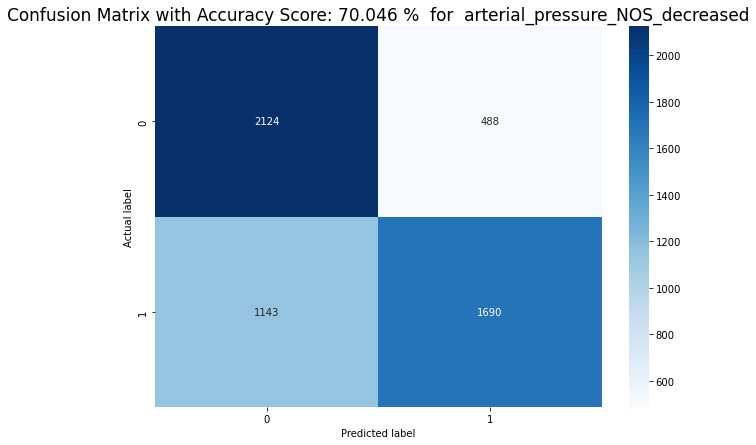

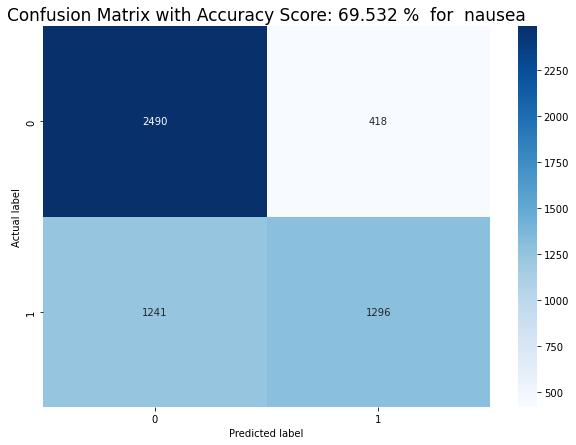

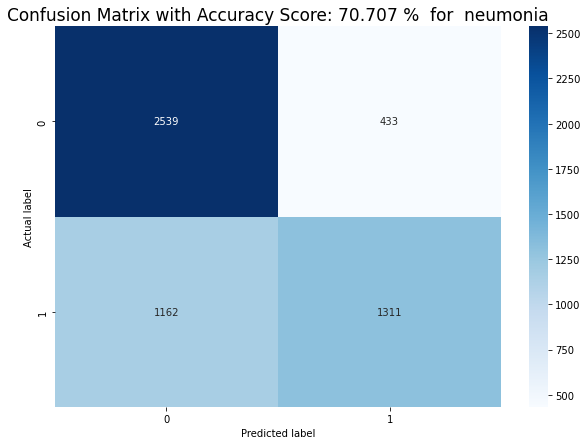

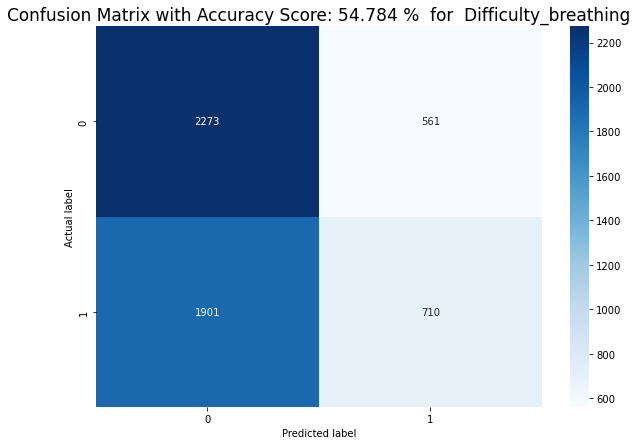

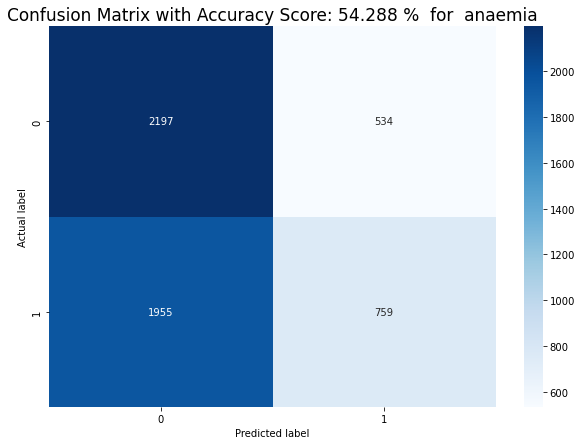

In [221]:
print('\n\nSeen Data\n')
preds_seen = (train_seen > 0.2).astype("int32")
report(test_seen, preds_seen, list(preds_seen.columns))

print('\n\nUnSeen Data\n')
preds_unseen = (train_unseen > 0.2).astype("int32")
report(test_unseen, preds_unseen, list(preds_unseen.columns))



Seen Data

classification report:
                                  precision    recall  f1-score   support

arterial_pressure_NOS_decreased       0.87      0.30      0.45      2833
                         nausea       0.87      0.24      0.38      2537
                       neumonia       0.85      0.25      0.38      2473

                      micro avg       0.87      0.27      0.41      7843
                      macro avg       0.87      0.26      0.40      7843
                   weighted avg       0.87      0.27      0.41      7843
                    samples avg       0.32      0.22      0.25      7843



UnSeen Data

classification report:
                       precision    recall  f1-score   support

Difficulty_breathing       0.64      0.05      0.09      2611
             anaemia       0.67      0.05      0.10      2714

           micro avg       0.66      0.05      0.10      5325
           macro avg       0.66      0.05      0.10      5325
        weighted avg     

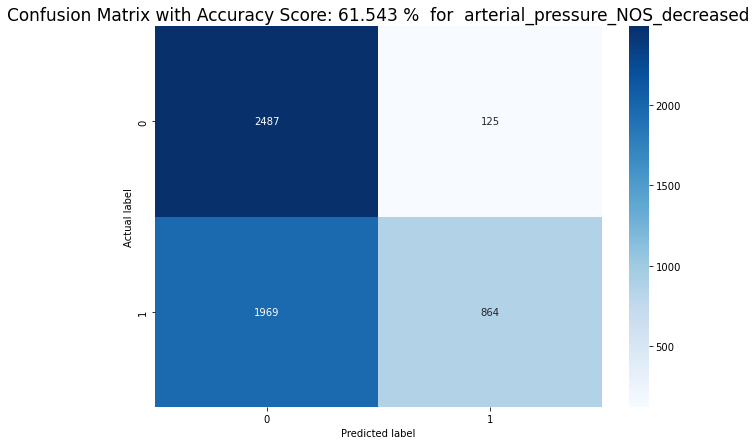

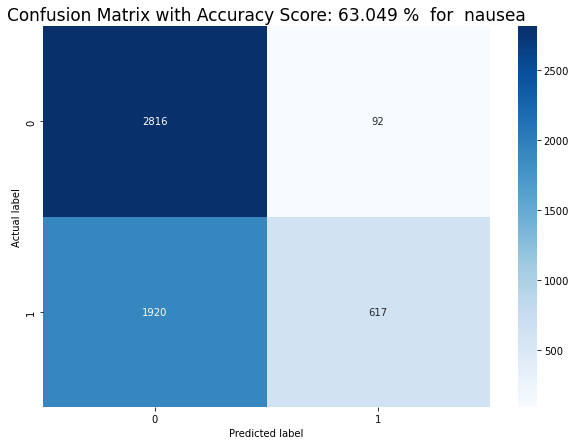

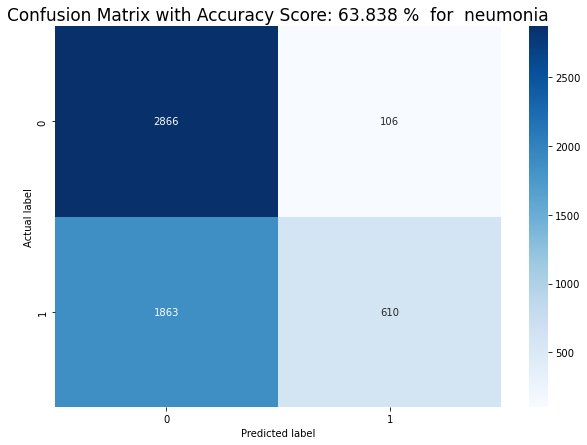

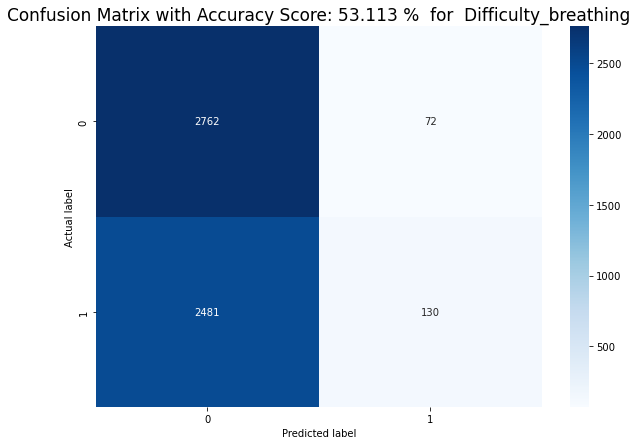

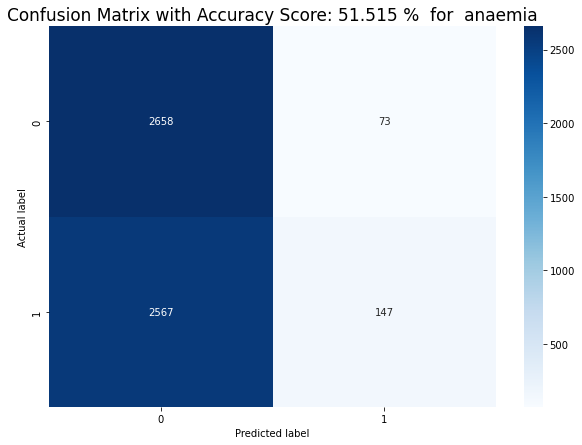

In [222]:
print('\n\nSeen Data\n')
preds_seen = (train_seen > 0.5).astype("int32")
report(test_seen, preds_seen, list(preds_seen.columns))

print('\n\nUnSeen Data\n')
preds_unseen = (train_unseen > 0.5).astype("int32")
report(test_unseen, preds_unseen, list(preds_unseen.columns))



Seen Data

classification report:
                                  precision    recall  f1-score   support

arterial_pressure_NOS_decreased       0.92      0.16      0.27      2833
                         nausea       0.92      0.12      0.20      2537
                       neumonia       0.91      0.12      0.21      2473

                      micro avg       0.92      0.13      0.23      7843
                      macro avg       0.92      0.13      0.23      7843
                   weighted avg       0.92      0.13      0.23      7843
                    samples avg       0.17      0.11      0.13      7843



UnSeen Data

classification report:
                       precision    recall  f1-score   support

Difficulty_breathing       0.81      0.01      0.03      2611
             anaemia       0.70      0.01      0.02      2714

           micro avg       0.76      0.01      0.02      5325
           macro avg       0.76      0.01      0.02      5325
        weighted avg     

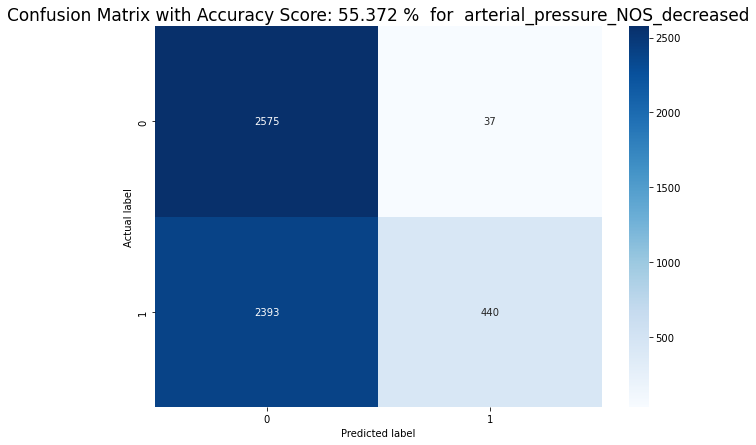

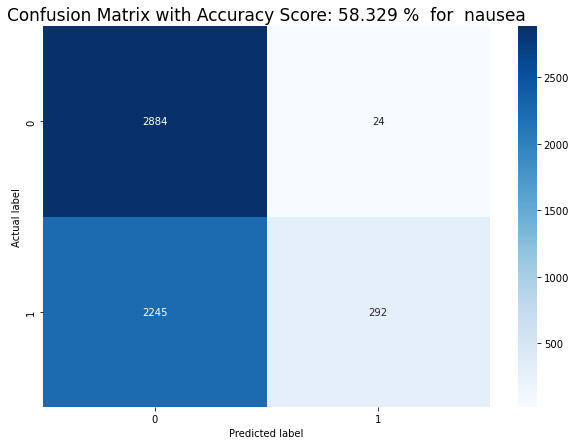

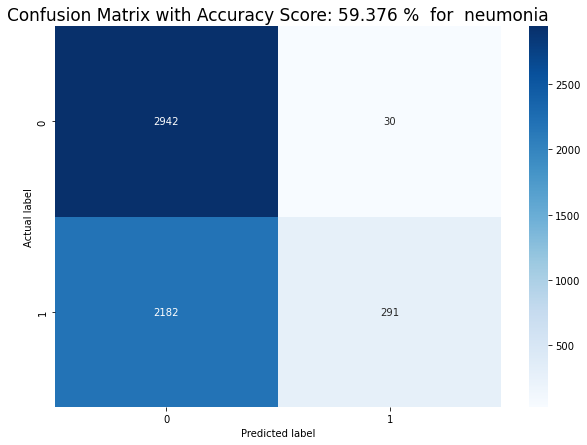

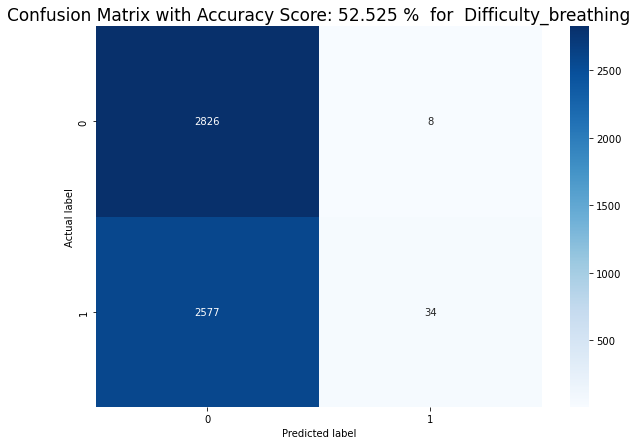

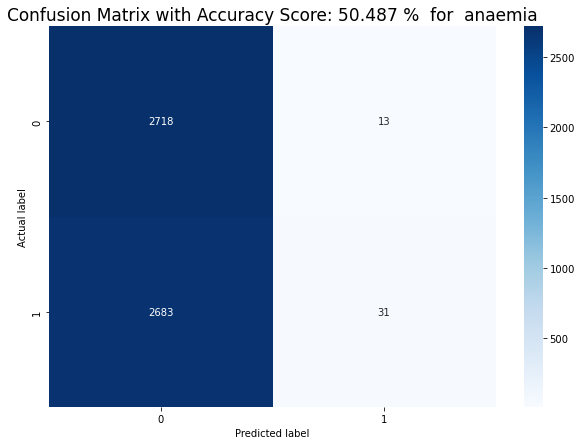

In [223]:
print('\n\nSeen Data\n')
preds_seen = (train_seen > 0.7).astype("int32")
report(test_seen, preds_seen, list(preds_seen.columns))

print('\n\nUnSeen Data\n')
preds_unseen = (train_unseen > 0.7).astype("int32")
report(test_unseen, preds_unseen, list(preds_unseen.columns))



Seen Data

classification report:
                                  precision    recall  f1-score   support

arterial_pressure_NOS_decreased       0.95      0.06      0.12      2833
                         nausea       0.95      0.04      0.08      2537
                       neumonia       0.93      0.05      0.09      2473

                      micro avg       0.94      0.05      0.10      7843
                      macro avg       0.94      0.05      0.10      7843
                   weighted avg       0.94      0.05      0.10      7843
                    samples avg       0.07      0.05      0.05      7843



UnSeen Data

classification report:
                       precision    recall  f1-score   support

Difficulty_breathing       0.83      0.00      0.00      2611
             anaemia       0.73      0.00      0.01      2714

           micro avg       0.76      0.00      0.00      5325
           macro avg       0.78      0.00      0.00      5325
        weighted avg     

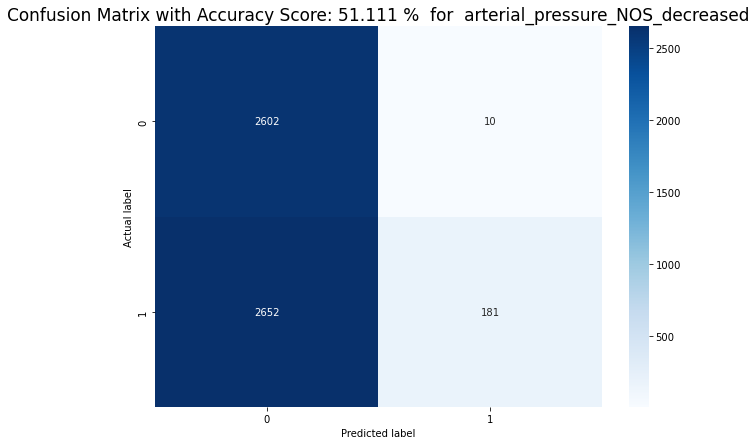

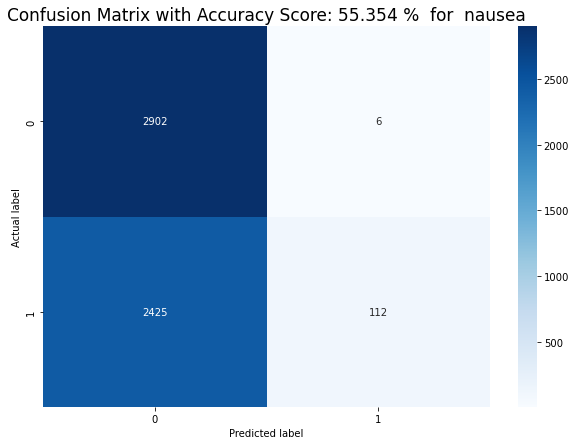

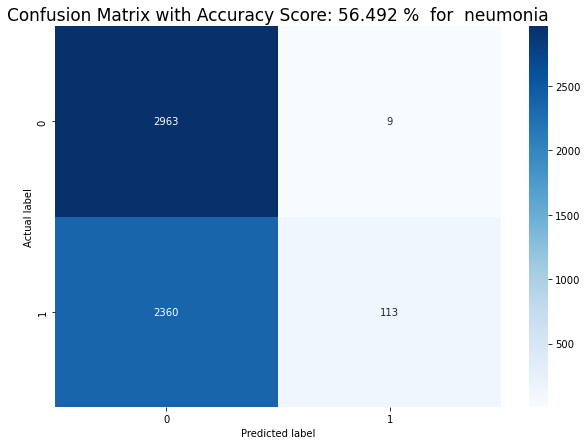

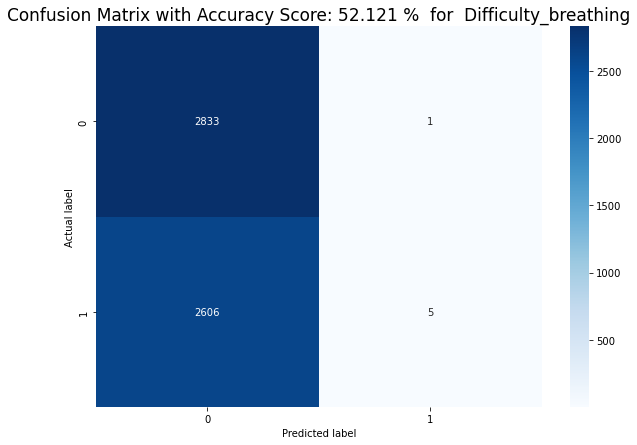

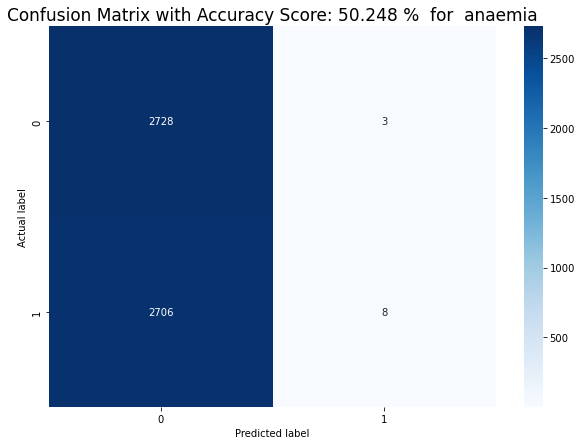

In [224]:
print('\n\nSeen Data\n')
preds_seen = (train_seen > 0.9).astype("int32")
report(test_seen, preds_seen, list(preds_seen.columns))

print('\n\nUnSeen Data\n')
preds_unseen = (train_unseen > 0.9).astype("int32")
report(test_unseen, preds_unseen, list(preds_unseen.columns))

### 9. NN

In [12]:
from sklearn.model_selection import train_test_split

# create train and test
train = train.to_numpy().astype('float32')
test = test.to_numpy().astype('int32')

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(train, test,
                                                    test_size=0.3, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.15, random_state= 8) # 0.15 x 0.7 = 0.105, 10.5% of data

                                                                                   # 0.85 x 0.7 = 0.105, 59.5% of data
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (3239, 5)
y_train shape: (3239, 5)
X_test shape: (1634, 5)
y_test shape: (1634, 5)
X_val shape: (572, 5)
y_val shape: (572, 5)


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# create neural network model to predict non-exclusive classes
def nn_model():
    model = Sequential()
    model.add(Dense(units=5,activation='relu'))
    model.add(Dense(units=15,activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(units=10,activation='relu'))
    model.add(Dense(units=5,activation='sigmoid'))

    
    # For a binary classification problem
    model.compile(optimizer='adam', loss='binary_crossentropy') # metrics=['accuracy']
    
    return model

In [ ]:
# simple early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model = nn_model()
# fit model
model.fit(X_train, y_train, batch_size = 32, epochs = 150, verbose = 1, 
          validation_data = (X_test, y_test))#, callbacks=[early_stop])

In [ ]:
# Here we can see parameters and output shapes in each layer
model.summary()

In [ ]:
model.metrics_names

In [ ]:
# model comparison of loss and accuracy between train and test 
model_loss = pd.DataFrame(model.history.history)
#model_loss[['accuracy','val_accuracy']].plot(figsize=(12,5), title='Compare accuracy of the model');
model_loss[['loss','val_loss']].plot(figsize=(12,5), title='Compare loss of the model');

In [ ]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_val, y_val, verbose = 0 )

print("Train loss: ", training_score)
print("Validation loss: ", test_score)
#print("Train accuracy: ", training_score[1])
#print("Test accuracy: ", test_score[1])

In [ ]:
y_val[:9,:]

In [ ]:
predictions[:9,:]